### Overview
* **TBATS** -
    * Trigonometric terms for seasonality
    * Box-Cox transformations for heterogeneity (transforming closer to normal)
    * ARMA errors for short-term dynamics
    * Trend (possibly damped)
    * Seasonal (including multiple and non-integer periods)
    * **Pros/Cons**:
        * handles non-integer seasonality, multiple seasonal periods (can also change over time)
        * entirely automated
        * $\color{red}{\text{prediction intervals often too wide}}$
        * $\color{red}{\text{does not accomodate exogenous regressors}}$
        * $\color{red}{\text{slow for long series}}$
    * **TBATS** package
        * Usage: model = estimator.fit(), model.forecast()
* Rob Hyndman's [slides](https://robjhyndman.com/nyc2018/3-2-TBATS.pdf)
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None

# Model
from tbats import TBATS

# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Suppress 'futurewarnings' from Statsmodels and TSA
# import warnings
# warnings.filterwarnings("ignore")

## Bike Sharing [dataset](https://www.kaggle.com/datasets/contactprad/bike-share-daily-data)

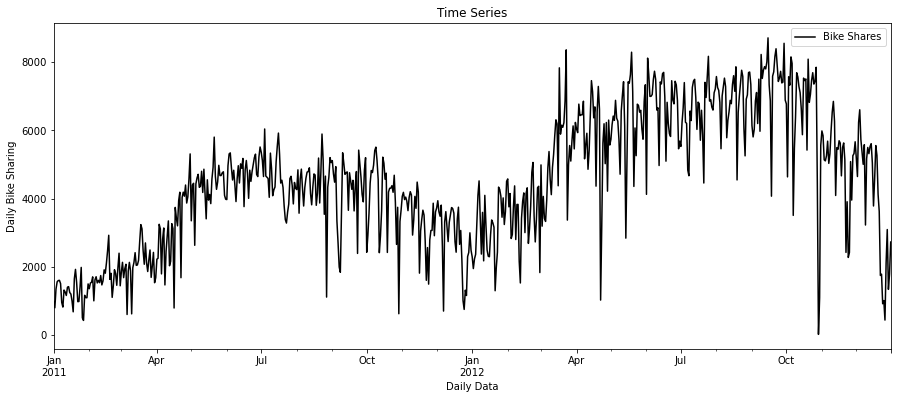

In [2]:
df = pd.read_csv('data/daily_bike_sharing.csv', index_col='dteday', parse_dates=True)
df = df.loc[:,['cnt', 'holiday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df = df.rename(columns={'cnt':'y'})
df = df.asfreq('D')
df['y'].plot(figsize=(15,6), legend=True, 
             ylabel='Daily Bike Sharing', xlabel='Daily Data',
             title='Time Series', label='Bike Shares', color='black');

In [3]:
# Train, Test split
test_period = 31
train = df.iloc[:-test_period, :]['y']
test  = df.iloc[-test_period:, :]['y']
print(train.shape, test.shape)

train_exog = df.iloc[:-test_period, :].drop(columns='y')
test_exog  = df.iloc[-test_period:, :].drop(columns='y')
print(train_exog.shape, test_exog.shape)

(700,) (31,)
(700, 7) (31, 7)


### Model: TBATS

In [4]:
model = TBATS(use_trend = True, seasonal_periods=[7, 365.5]).fit(train)

In [5]:
type(model)

tbats.tbats.Model.Model

In [6]:
preds = pd.Series(model.forecast(steps = test_period), index=test.index)
preds[:5]

dteday
2012-12-01    4828.272249
2012-12-02    4482.064414
2012-12-03    4362.513961
2012-12-04    4305.123489
2012-12-05    4260.338328
Freq: D, dtype: float64

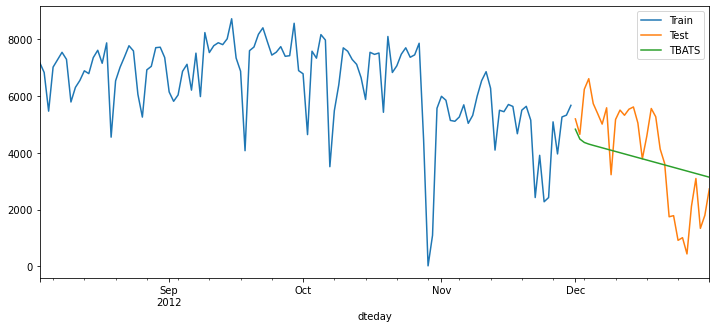

In [7]:
plt.figure(figsize = (12,5))
train[-120:].plot(label = 'Train');   #plotting last few days for better graphs
test.plot(label = 'Test');
preds.plot(label = 'TBATS');
plt.legend(loc='best');

In [8]:
print('Average level: ', round(df['y'].mean(),0))
print('MAE:  ', mean_absolute_error(test, preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test, preds)).round(0))
print('MAPE: ', round(((test - preds)/test).abs().mean()*100,2))

Average level:  4504.0
MAE:   1299.0
RMSE:  1494.0
MAPE:  68.06


In [9]:
preds.to_csv('preds_tbats.csv')

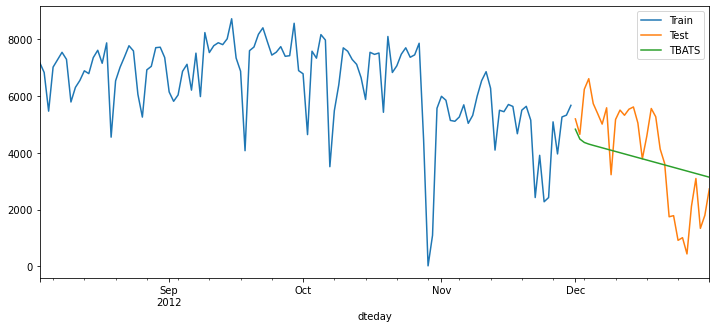

In [10]:
model2 = TBATS(use_trend = True, seasonal_periods=[365]).fit(train)
preds2 = pd.Series(model2.forecast(steps = test_period), index=test.index)

plt.figure(figsize = (12,5))
train[-120:].plot(label = 'Train');
test.plot(label = 'Test');
preds2.plot(label = 'TBATS');
plt.legend(loc='best');

---
## Another dataset - Store Footfall dataset

In [11]:
df = pd.read_csv('data/daily-footfall.csv', index_col='WeekBeginning')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

In [12]:
df.head()

,AveragePerDay
WeekBeginning,
2016-01-03,235
2016-01-10,231
2016-01-17,233
2016-01-24,224
2016-01-31,224


In [13]:
df = df.asfreq('W') 
df.index[:5]

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31'],
              dtype='datetime64[ns]', name='WeekBeginning', freq='W-SUN')

In [14]:
# df.isna().sum()
# df[df.isna().values]

<AxesSubplot:xlabel='WeekBeginning'>

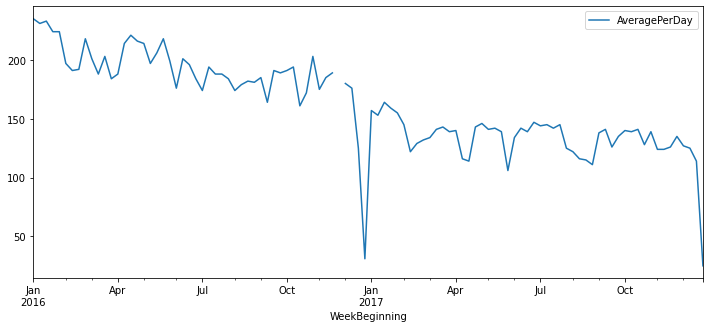

In [15]:
df.plot(figsize=(12,5))

In [16]:
df.query('index > "10-Nov-2016" and index < "15-Dec-2016"')

,AveragePerDay
WeekBeginning,
2016-11-13,185.0
2016-11-20,189.0
2016-11-27,NaN
2016-12-04,180.0
2016-12-11,176.0


In [17]:
df = df.fillna(method='ffill') # 2016-11-27 is missing and gets back-filled

In [18]:
df.query('index > "10-Nov-2016" and index < "15-Dec-2016"')

,AveragePerDay
WeekBeginning,
2016-11-13,185.0
2016-11-20,189.0
2016-11-27,189.0
2016-12-04,180.0
2016-12-11,176.0


<AxesSubplot:xlabel='WeekBeginning'>

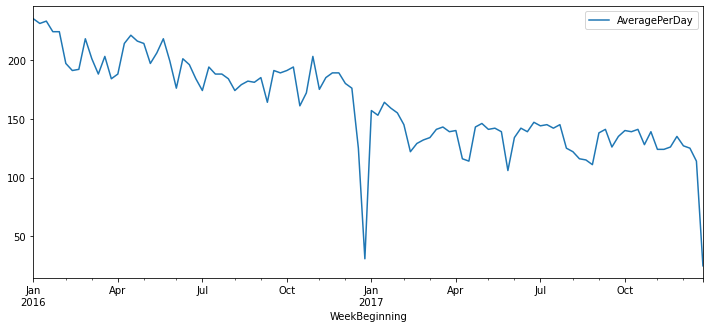

In [19]:
df.plot(figsize=(12,5))

In [20]:
# Train, Test split
test_period = 5
train = df.iloc[:-test_period, :]
test  = df.iloc[-test_period:, :]

In [21]:
model = TBATS(seasonal_periods=[52]).fit(train)

In [22]:
preds = pd.Series(model.forecast(steps = test_period), index=test.index)
preds[:5]

WeekBeginning
2017-11-26    138.885776
2017-12-03    124.805038
2017-12-10    124.754280
2017-12-17     70.525063
2017-12-24    -19.762567
Freq: W-SUN, dtype: float64

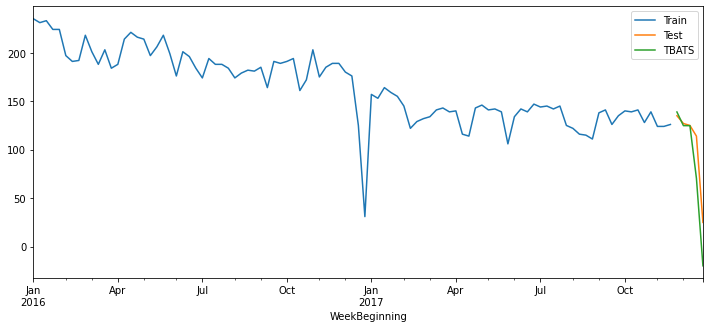

In [23]:
plt.figure(figsize = (12,5))
train['AveragePerDay'].plot(label = 'Train');   
test['AveragePerDay'].plot(label = 'Test');
preds.plot(label = 'TBATS');
plt.legend(loc='best');

In [24]:
print('Average level: ', round(df['AveragePerDay'].mean(),0))
print('MAE:  ', mean_absolute_error(test['AveragePerDay'], preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['AveragePerDay'], preds)).round(0))
print('MAPE: ', round(((test['AveragePerDay'] - preds)/test['AveragePerDay']).abs().mean()*100,2))

Average level:  162.0
MAE:   19.0
RMSE:  28.0
MAPE:  44.4


In [25]:
print(preds)
print(test)    

# Error gets pushed up because of last two values
print('MAPE: ', round((test['AveragePerDay'] - preds)/test['AveragePerDay']*100,2))

WeekBeginning
2017-11-26    138.885776
2017-12-03    124.805038
2017-12-10    124.754280
2017-12-17     70.525063
2017-12-24    -19.762567
Freq: W-SUN, dtype: float64
               AveragePerDay
WeekBeginning               
2017-11-26             135.0
2017-12-03             127.0
2017-12-10             125.0
2017-12-17             114.0
2017-12-24              25.0
MAPE:  WeekBeginning
2017-11-26     -2.88
2017-12-03      1.73
2017-12-10      0.20
2017-12-17     38.14
2017-12-24    179.05
Freq: W-SUN, dtype: float64


## Alternate approaches - SARIMAX performs better
* HoltWinters cannot accomodate run 52week seasonality due to insufficient data

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# not enough data to run 52 week seasonality
model_hw = ExponentialSmoothing(endog = train['AveragePerDay'], initialization_method=None,
                                trend = 'add', seasonal = 'mul', seasonal_periods = 4).fit() # !!!!

preds_hw = model_hw.forecast(steps=test_period).rename('HW')

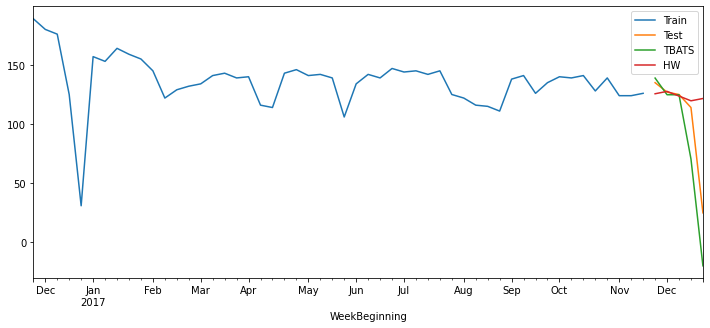

In [27]:
plt.figure(figsize = (12,5))
train['AveragePerDay'][-52:].plot(label = 'Train');
test['AveragePerDay'].plot(label = 'Test');
preds.plot(label = 'TBATS');
preds_hw.plot(label = 'HW');
plt.legend(loc='best');

In [28]:
from pmdarima import auto_arima

model = auto_arima(y = train, m = 52, seasonal = True)
preds_sarimax = pd.Series(model.predict(n_periods = test_period,), index=test.index)

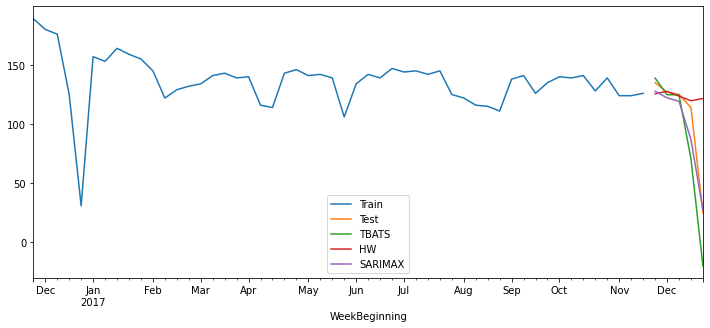

In [29]:
plt.figure(figsize = (12,5))
train['AveragePerDay'][-52:].plot(label = 'Train');
test['AveragePerDay'].plot(label = 'Test');
preds.plot(label = 'TBATS');
preds_hw.plot(label = 'HW');
preds_sarimax.plot(label = 'SARIMAX');
plt.legend(loc='best');

In [30]:
print('RMSE w/ TBATS: ', np.sqrt(mean_squared_error(test['AveragePerDay'], preds)).round(0))
print('RMSE w/ HoltWinters: ', np.sqrt(mean_squared_error(test['AveragePerDay'], preds_hw)).round(0))
print('RMSE w/ SARIMAX: ',     np.sqrt(mean_squared_error(test['AveragePerDay'], preds_sarimax)).round(0))

RMSE w/ TBATS:  28.0
RMSE w/ HoltWinters:  43.0
RMSE w/ SARIMAX:  13.0
